In [1]:
import torch
from torch import nn, optim     # layer / optimizer 라이브러리
import torch.nn.functional as F
from torch.utils.data import DataLoader     # dataset 가져오기
from torchvision import datasets, transforms    #데이터 전처리
import matplotlib.pyplot as plt    #시각화
from torch import random
import numpy as np
from torch.utils.data import random_split

# hyper_parameter: 모델을 구성하는 과정에서 개발자가 수정할 수 있는 파라미터
    ex:
    input_size = 28*28 | mnist 사이즈 크기
    hidden_size = 128 : mlp | 히든 레이어 수
    num_classes: 10 | mnist 손글씨 최종 분류 클래스 개수(0~9)
    num_epoches : 10 | 몇 번 학습할지 정하는 학습 단위
    batch_size: 데이터를 학습시킬 때, 일반적인 패턴을 학습시키기 위해서 데이터를 쪼개 구분하는 수
    learning_rate : 0.001 | 모델이 한 번 학습 당 업데이트 되는 정도


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# dataset 로드 및 전처리 정의

In [3]:
# data 값을 0~1 사이 값으로 전처리(normalization)
# 입력 data 값을 tensor로 변환

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]) #mean 0.5, std 0.5

In [4]:
# datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
#   train: paramter에 영향 有
#   download = true : 다운로드해서 실행
#   transform = transform : 위에서 실행한 전처리를 적용한 채로, 데이터를 다운로드

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=transform)

In [5]:
input_size = 28*28 # mnist 사이즈 크기
hidden_size = 128 # mlp | 히든 레이어 수
num_classes = 10 # mnist 손글씨 최종 분류 클래스 개수(0~9)
num_epochs = 10 # 몇 번 학습할지 정하는 학습 단위
batch_size = 64 # 데이터를 학습시킬 때, 일반적인 패턴을 학습시키기 위해서 데이터를 쪼개 구분하는 수
learning_rate = 0.001 # 모델이 한 번 학습 당 업데이트 되는 정도

In [6]:
# dataset : train(80%)
#           val(10%)
#           test(10%)

train_size = int(0.8*(len(train_data)))
val_size = int(len(train_data) - train_size)

# train_data를 train, val로 random 하게 나눔
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # all num of hidden_parameter : 28*28*128+128(bias 수): 100,480
            # 28*28 = input data 수
            # 128: hidden_layer 수
            # +128: bias 수
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_size, num_classes)


    # model 기능 구조 디자인
    def forward(self, x):
        # x : input_data
        # x resize-> batch_size(784, 1)
        # Linear : only 1차원만 학습; 1차원으로 resize해야 함
        #
        x = x.view(-1, input_size)
        x = self.input_layer(x)
        x = self.sigmoid(x)
        x = self.output_layer(x)

        return x

In [8]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [9]:
model = MLP(input_size, hidden_size, 10)
model.to(device) #cpu 구동->gpu 구동

MLP(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
from torchsummary import summary

summary(model, (1, 28*28)) # model 정보를 정리 보여줌

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
           Sigmoid-2                  [-1, 128]               0
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [11]:
# 손실 함수 : 정답 데이터, 추정치 사이의 차이 계산

crierion = nn.CrossEntropyLoss()    # 분류에 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
input_layer_weight = model.input_layer.weight.shape
input_bias_shape = model.input_layer.bias.shape

print(f'Input_Layer_weight: {input_layer_weight},\tInput_Layer_bias: {input_bias_shape}')

Input_Layer_weight: torch.Size([128, 784]),	Input_Layer_bias: torch.Size([128])


In [13]:
best_val_acc = 0
best_model = None
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # ===== Validation =====
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    # 최적 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()  # 모델 파라미터 저장

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Acc: {val_acc:.2f}%")


Epoch [1/10], Train Loss: 0.6132, Train Acc: 79.70%, Val Acc: 83.30%
Epoch [2/10], Train Loss: 0.4132, Train Acc: 85.24%, Val Acc: 84.97%
Epoch [3/10], Train Loss: 0.3723, Train Acc: 86.79%, Val Acc: 85.45%
Epoch [4/10], Train Loss: 0.3471, Train Acc: 87.58%, Val Acc: 86.81%
Epoch [5/10], Train Loss: 0.3265, Train Acc: 88.35%, Val Acc: 86.97%
Epoch [6/10], Train Loss: 0.3106, Train Acc: 88.81%, Val Acc: 87.84%
Epoch [7/10], Train Loss: 0.2954, Train Acc: 89.36%, Val Acc: 87.79%
Epoch [8/10], Train Loss: 0.2846, Train Acc: 89.74%, Val Acc: 87.98%
Epoch [9/10], Train Loss: 0.2729, Train Acc: 90.11%, Val Acc: 88.25%
Epoch [10/10], Train Loss: 0.2624, Train Acc: 90.56%, Val Acc: 88.41%


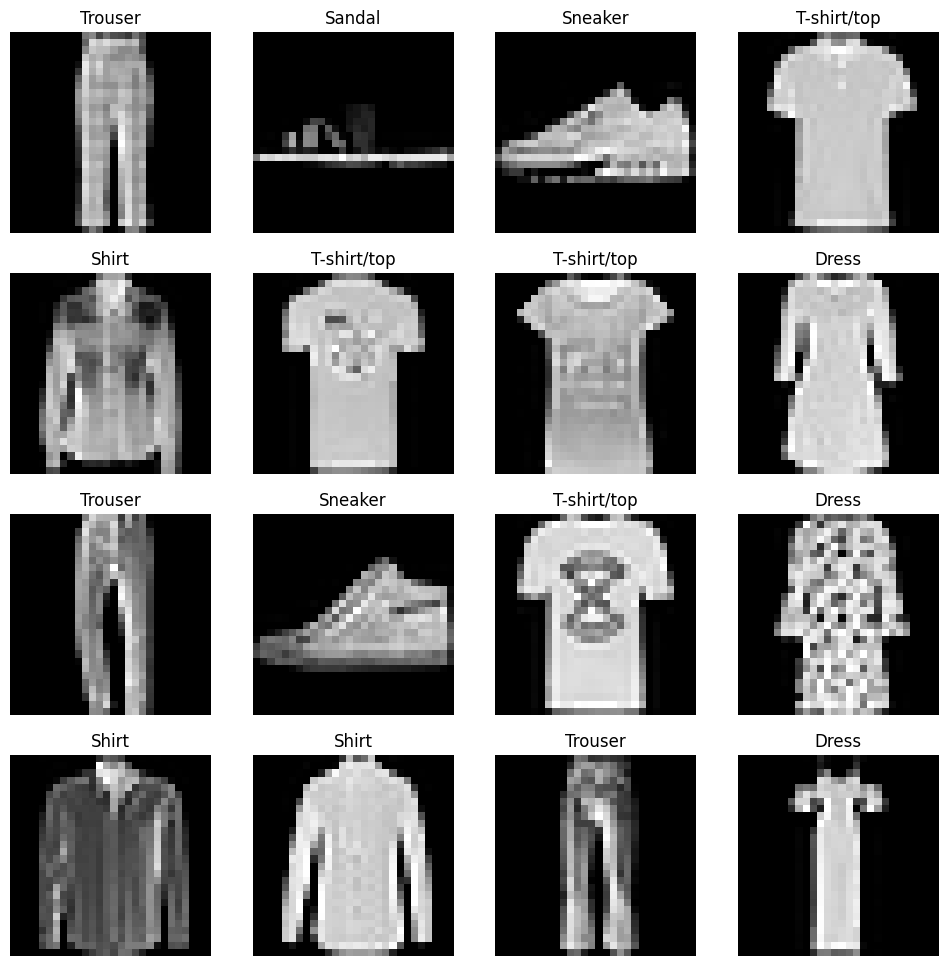

In [15]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4

# 보통 DataLoader에서 한 배치 가져오기
data_iter = iter(train_loader)
images, labels = next(data_iter)

for i in range(1, cols * rows + 1):
    image = images[i].squeeze().cpu()  # ✅ GPU -> CPU
    label_idx = labels[i].item()
    label = labels_map[label_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1,8,3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*13*13, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # 28x28x3
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = ConvNet()
net.to(device)
print(net)

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

In [ ]:
input = torch.randn(1,1,28,28)
out = net(input.to(device))
print(out)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
total_batch = len(train_loader)
print(total_batch)

In [ ]:
for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print('epoch: {}, iter: {}, loss: {}'.format(epoch+1, i+1, running_loss/100))
            running_loss = 0.0

In [ ]:
path = './model.pth'
torch.save(net.state_dict(), path)

In [ ]:
net = ConvNet()
net.load_state_dict(torch.load(path))

In [ ]:
net.parameters

In [ ]:
def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()

    fig = plt.figure(figsize=(16,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [ ]:
import torchvision
import numpy as np

dataiter = iter(test_loader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:6]))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print(predicted)

In [ ]:
print(''.join('{}, '.format(labels_map[int(predicted[j].numpy())]) for j in range(6)))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100*correct/total)
